## 0. Preamble

In [1]:
%load_ext autoreload
%autoreload 2

import sys
if "../src" not in sys.path:
    sys.path.append("../src")

In [2]:
import pandas as pd
import json
from dataclasses import dataclass
import numpy as np
from generation.graph import SATGraph
import seaborn as sns
import functools
from IPython.display import display
import matplotlib.pyplot as plt

sns.set()

In [3]:
def savefig(name: str, **kwargs):
    kwargs.setdefault("dpi", 200)
    kwargs.setdefault("bbox_inches", "tight")
    kwargs.setdefault("transparent", True)
    plt.savefig(name, **kwargs)


In [4]:
@dataclass
class LoadedHistory:
    step: pd.DataFrame
    episode: pd.DataFrame


def parse_template(raw_template: str) -> SATGraph:
    return SATGraph.from_template(np.asarray(json.loads(raw_template)))


def load_history(
    directory: str, limit_episodes: int | None = None, base="../lamgate/runs/SAGE"
) -> LoadedHistory:
    directory = base + "/" + directory
    step = pd.read_csv(directory + "/history_step.csv")
    episode = pd.read_csv(directory + "/history_episode.csv")

    if limit_episodes is not None:
        step = step[step["episode"] < limit_episodes]
        episode = episode[episode["episode"] < limit_episodes]

    print("Loaded history from", directory.split("/")[-1])

    return LoadedHistory(step, episode)


In [5]:
def get_perf(h: LoadedHistory):
    step = h.step.iloc[1:]
    data = []
    index = []
    for col in ("sample_pairs", "step", "predict"):
        index.append(col)
        data.append(step["timing/" + col].mean())

    # Add the logger timing
    n = len(h.step)
    index.append("logger")
    data.append(h.episode["timing/logger"].sum() / n)
    return pd.Series(data, index=index)

In [58]:
def get_metrics_per_episode(h: LoadedHistory):
    # Get the last step per episode
    df = h.step.loc[h.step.groupby("episode")["step"].idxmax()]
    metric_cols = [col for col in df.columns if col.startswith("metrics/")]
    df = df.set_index("episode")[metric_cols]
    return df.rename({col: col.split("/")[1] for col in metric_cols}, axis=1)


def plot_metrics(
    hs: dict[str, LoadedHistory],
    metric: str = "time_cpu",
    experiments_label="experiment",
    window_size: int = 200,
    use_median: bool = True,
    last_episodes: int = 200,
    saveto: str | None = None,
    title: str | None = None,
    move_legend: bool=False,
):
    metrics = []
    metrics_end = []
    for name, h in hs.items():
        if use_median:
            m = get_metrics_per_episode(h).rolling(window_size).median().reset_index()
        else:
            m = get_metrics_per_episode(h).rolling(window_size).mean().reset_index()
        m[experiments_label] = name
        metrics.append(m)
        metrics_end.append(m.iloc[-last_episodes:])
    metrics = pd.concat(metrics, ignore_index=True)
    metrics_end = pd.concat(metrics_end, ignore_index=True)
    plt.figure()

    sns.lineplot(x="episode", y=metric, hue=experiments_label, data=metrics)
    metric_str = "CPU Time" if metric == "time_cpu" else metric.title()
    mode_str = "median" if use_median else "avg."
    plt.ylabel(f"Moving {mode_str} of {metric_str} (window size={window_size})")
    plt.xlabel("Episode")
    if title:
        plt.title(title)
    if move_legend:
        sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))
    plt.tight_layout()
    if saveto:
        savefig(saveto + "-lineplot.png")


## 1. Initial experiments

In [7]:
s1_base = load_history("s1 (base run)", limit_episodes=1500)
s1_uniform = load_history("s1 (test_uniform_sampling)", limit_episodes=1500)

s1_comp = load_history("s1 (comp_obs)", limit_episodes=1500)
s1_int = load_history("s1 (int_rewards)", limit_episodes=1500)
s1_overlaps = load_history("s1 (overlaps)", limit_episodes=1500)
s1_int_overlaps = load_history("s1 (int_rewards)", limit_episodes=1500)
s1_overlaps_decisions = load_history("s1 (overlaps, metric=decisions)", limit_episodes=1500)
s1_int_overlaps_decisions = load_history("s1 (overlaps, int_rewards, metric=decisions)", limit_episodes=1500)


Loaded history from s1 (base run)
Loaded history from s1 (test_uniform_sampling)
Loaded history from s1 (comp_obs)
Loaded history from s1 (int_rewards)
Loaded history from s1 (overlaps)
Loaded history from s1 (int_rewards)
Loaded history from s1 (overlaps, metric=decisions)
Loaded history from s1 (overlaps, int_rewards, metric=decisions)


### 1.1 G2SAT Sampling Performance

In [8]:
perf = pd.concat([get_perf(s1_base), get_perf(s1_uniform)], axis=1).T
perf["step"] -= perf["sample_pairs"]
perf.index = ["g2sat", "uniform"]
perf = perf.reset_index(names=["sampling_method"]).melt(
    id_vars=["sampling_method"],
    var_name="component",
    value_name="timing",
)


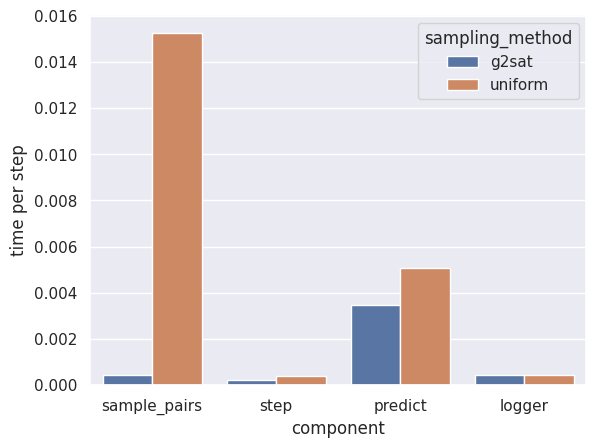

In [9]:
sns.barplot(x="component", y="timing", hue="sampling_method", data=perf)
plt.ylabel("time per step")
savefig("figs/perf_comparison_sampling.png")

### 1.2 Results

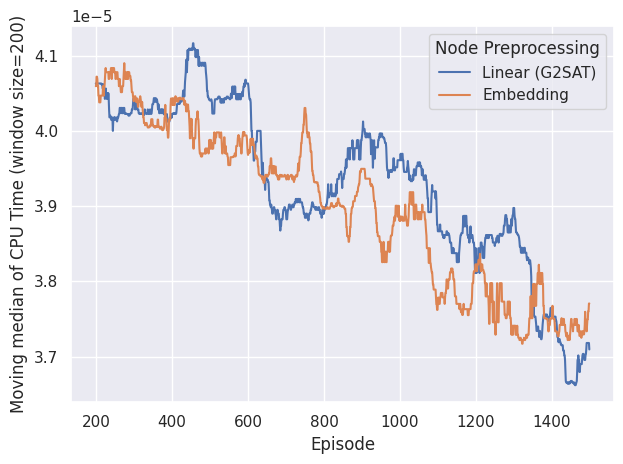

In [10]:
# Embedding
plot_metrics({"Linear (G2SAT)": s1_base, "Embedding": s1_comp}, experiments_label="Node Preprocessing", saveto="figs/s1_embedding")

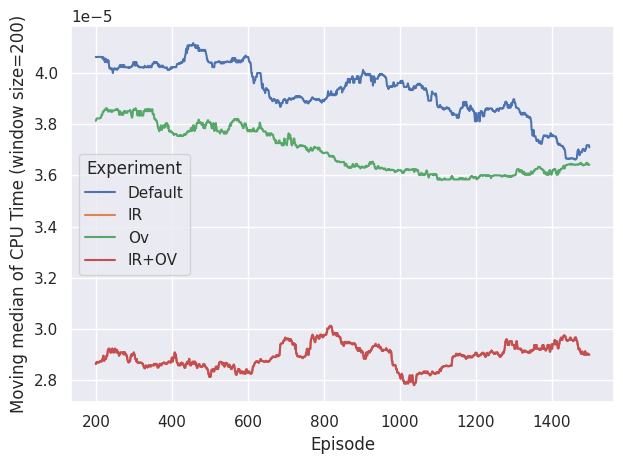

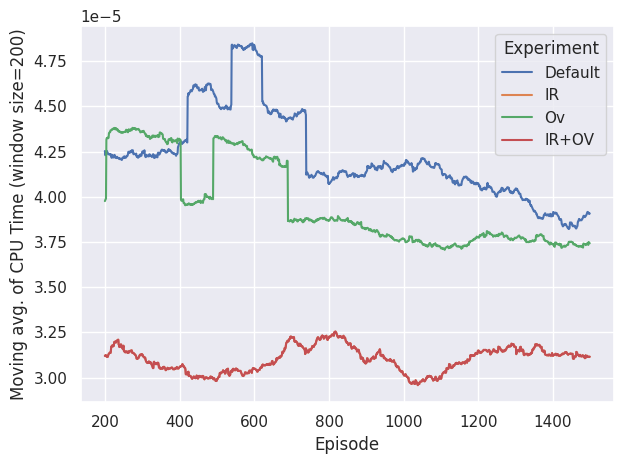

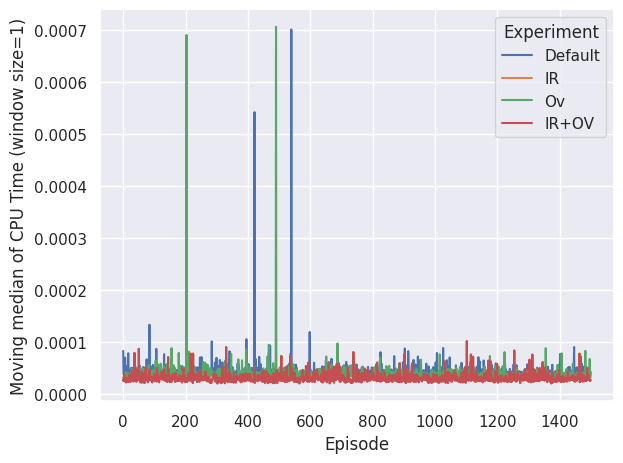

In [11]:
# IR/OV
plot_metrics({"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps}, experiments_label="Experiment", saveto="figs/s1_ir_ov")
plot_metrics({"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps}, experiments_label="Experiment", saveto="figs/s1_ir_ov_mean", use_median=False)
plot_metrics({"Default": s1_base, "IR": s1_int, "Ov": s1_overlaps, "IR+OV": s1_int_overlaps}, experiments_label="Experiment", saveto="figs/s1_ir_ov_w1", window_size=1)


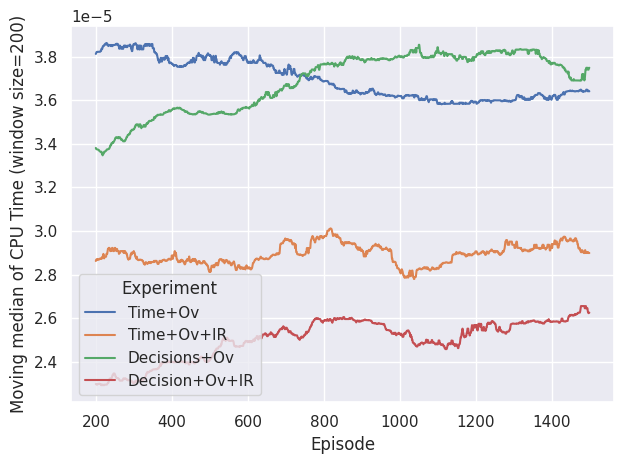

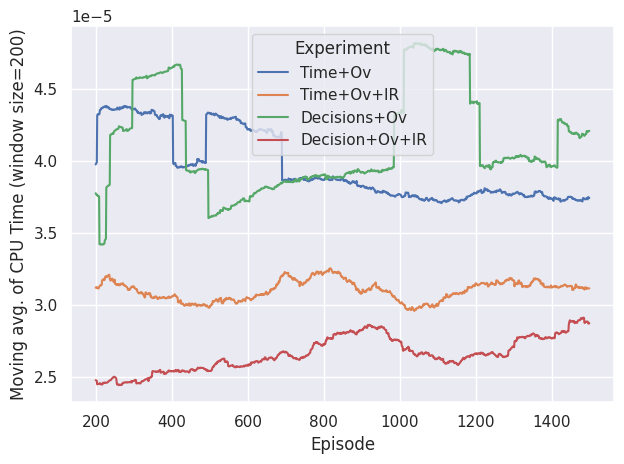

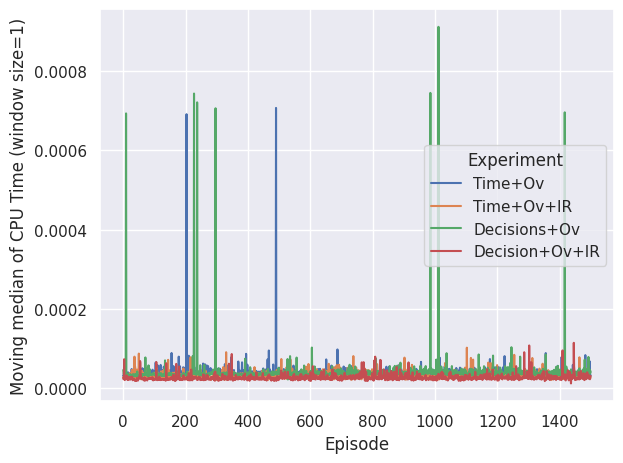

In [12]:
# IR/OV
plot_metrics({"Time+Ov": s1_overlaps, "Time+Ov+IR": s1_int_overlaps, "Decisions+Ov": s1_overlaps_decisions, "Decision+Ov+IR": s1_int_overlaps_decisions}, experiments_label="Experiment", saveto="figs/s1_decision")
plot_metrics({"Time+Ov": s1_overlaps, "Time+Ov+IR": s1_int_overlaps, "Decisions+Ov": s1_overlaps_decisions, "Decision+Ov+IR": s1_int_overlaps_decisions}, experiments_label="Experiment", saveto="figs/s1_decision_mean", use_median=False)
plot_metrics({"Time+Ov": s1_overlaps, "Time+Ov+IR": s1_int_overlaps, "Decisions+Ov": s1_overlaps_decisions, "Decision+Ov+IR": s1_int_overlaps_decisions}, experiments_label="Experiment", saveto="figs/s1_decision_w1", window_size=1)


(2e-05, 5.5e-05)

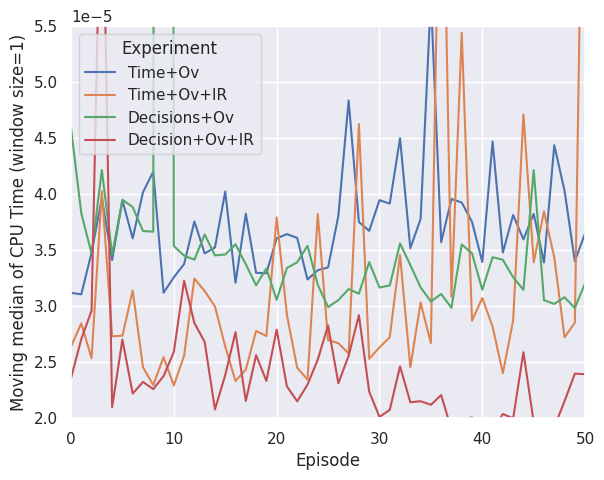

In [78]:
plot_metrics({"Time+Ov": s1_overlaps, "Time+Ov+IR": s1_int_overlaps, "Decisions+Ov": s1_overlaps_decisions, "Decision+Ov+IR": s1_int_overlaps_decisions}, experiments_label="Experiment", window_size=1)
plt.xlim(0, 50)
plt.ylim(2e-5, 5.5e-5)


## 2. Overlaps

In [13]:
s2_base = {}
s2_overlaps = {}

metrics = ["time_cpu", "decisions", "propagations", "conflicts", "restarts"]
for metric in metrics:
    s2_base[metric] = load_history(f"s2 (metric={metric})")
    s2_overlaps[metric] = load_history(f"s2 (metric={metric}, overlaps)")

s2_int_overlaps = {
    "decisions": load_history("s2 (metric=decisions, overlaps, int_rewards)")
}


Loaded history from s2 (metric=time_cpu)
Loaded history from s2 (metric=time_cpu, overlaps)
Loaded history from s2 (metric=decisions)
Loaded history from s2 (metric=decisions, overlaps)
Loaded history from s2 (metric=propagations)
Loaded history from s2 (metric=propagations, overlaps)
Loaded history from s2 (metric=conflicts)
Loaded history from s2 (metric=conflicts, overlaps)
Loaded history from s2 (metric=restarts)
Loaded history from s2 (metric=restarts, overlaps)
Loaded history from s2 (metric=decisions, overlaps, int_rewards)


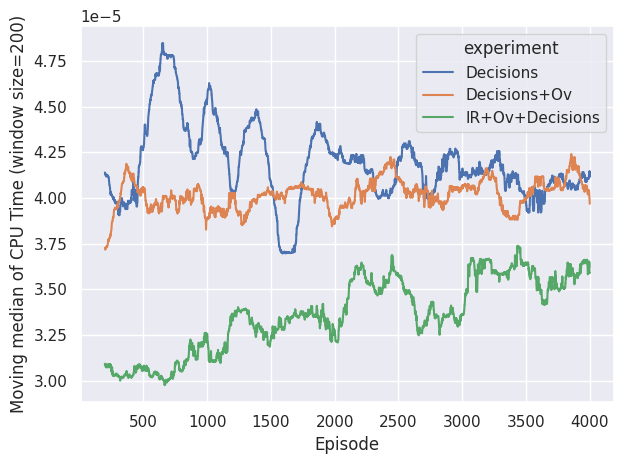

In [14]:
plot_metrics(
    {
        "Decisions": s2_base["decisions"],
        "Decisions+Ov": s2_overlaps["decisions"],
        "IR+Ov+Decisions": s2_int_overlaps["decisions"],
    },
    saveto="figs/s2_decisions_cmp",
)


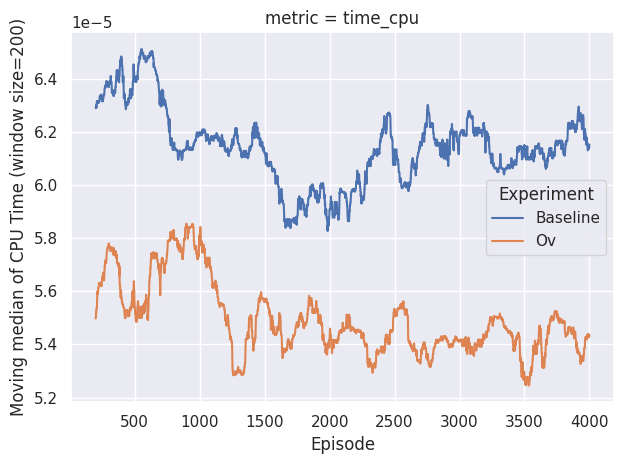

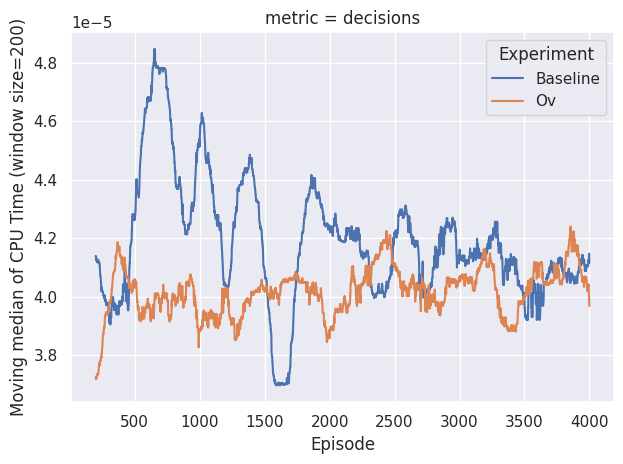

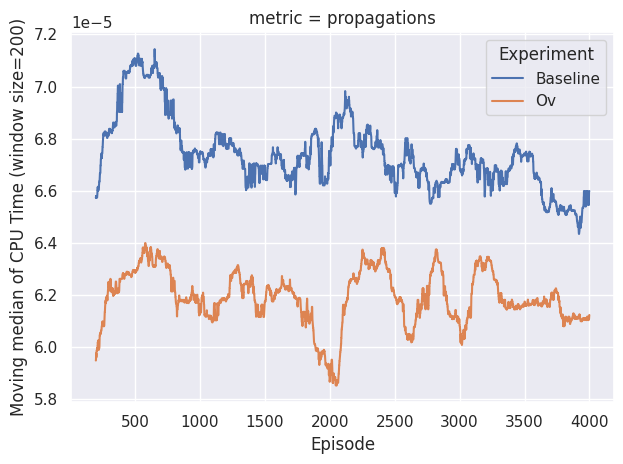

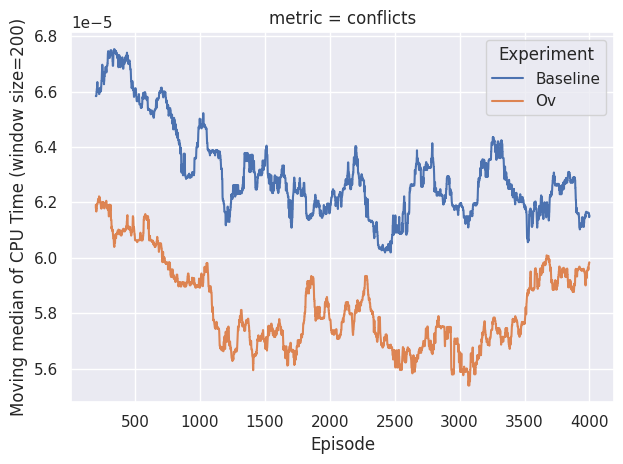

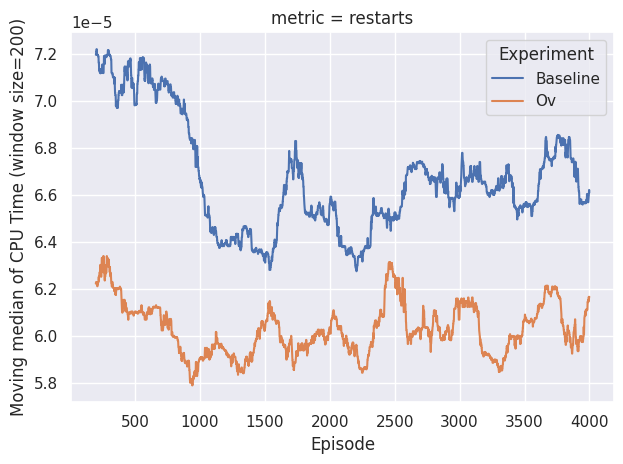

In [15]:
for metric in metrics:
    plot_metrics(
        {"Baseline": s2_base[metric], "Ov": s2_overlaps[metric]},
        experiments_label="Experiment",
        saveto=f"figs/s2_metric={metric}",
        title=f"metric = {metric}"
    )


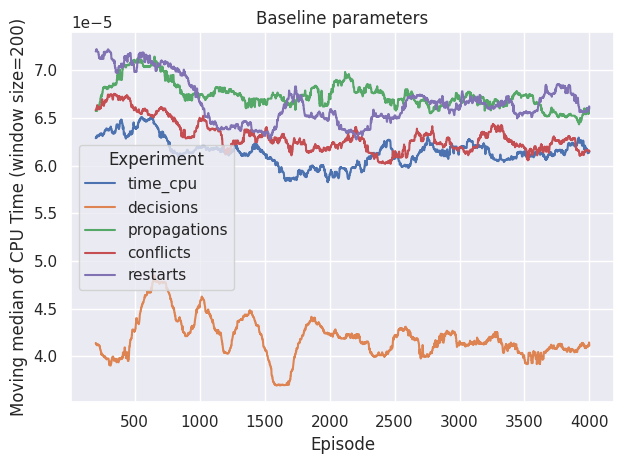

In [16]:
plot_metrics(
    s2_base,
    experiments_label="Experiment",
    saveto=f"figs/s2_base_cmp",
    title=f"Baseline parameters",
)


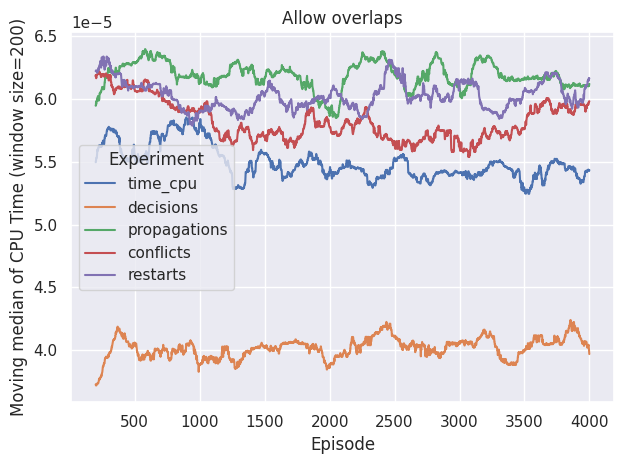

In [17]:
plot_metrics(
    s2_overlaps,
    experiments_label="Experiment",
    saveto=f"figs/s2_overlaps_cmp",
    title=f"Allow overlaps",
)


#### 2.1. Correlation between metrics

In [18]:
def get_episode_metrics(history: LoadedHistory):
    step_results = s2_int_overlaps["decisions"].step

    final_steps = step_results.groupby("episode")["step"].idxmax()
    episode_results = step_results.loc[final_steps]

    metric_cols = [col for col in episode_results.columns if col.startswith("metrics/")]
    episode_results = episode_results.loc[:, metric_cols]
    episode_results.rename(
        columns={col: col.removeprefix("metrics/") for col in metric_cols}, inplace=True
    )
    return episode_results


results = pd.concat(
    [get_episode_metrics(history) for history in list(s2_int_overlaps.values())]
)


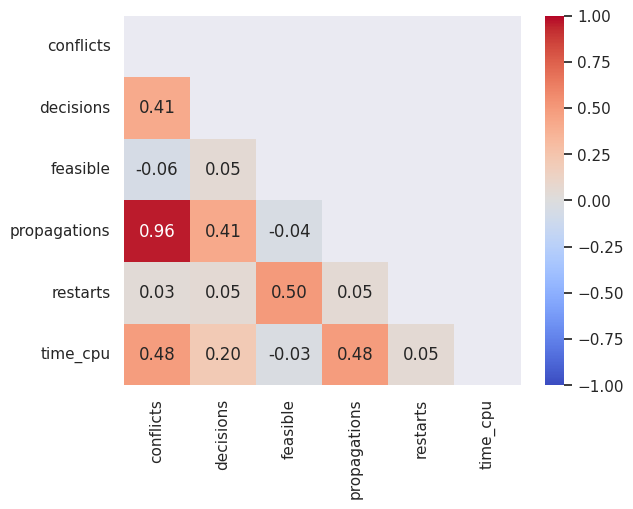

In [19]:
corr = results.corr("spearman")
corr_mask = np.triu(np.ones(len(corr)))
sns.heatmap(corr, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f", mask=corr_mask)
plt.grid()
savefig("figs/s2.1_metrics_corr.png")

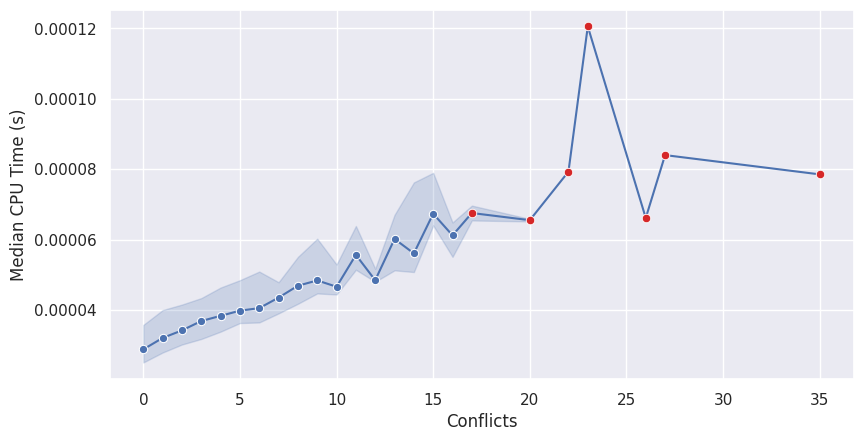

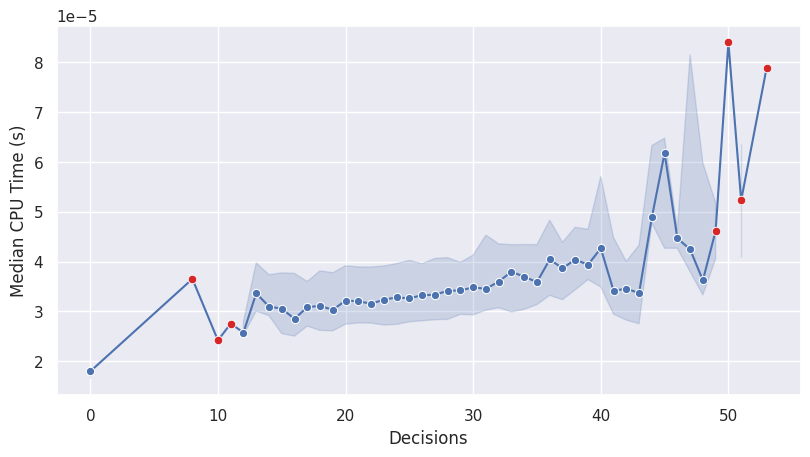

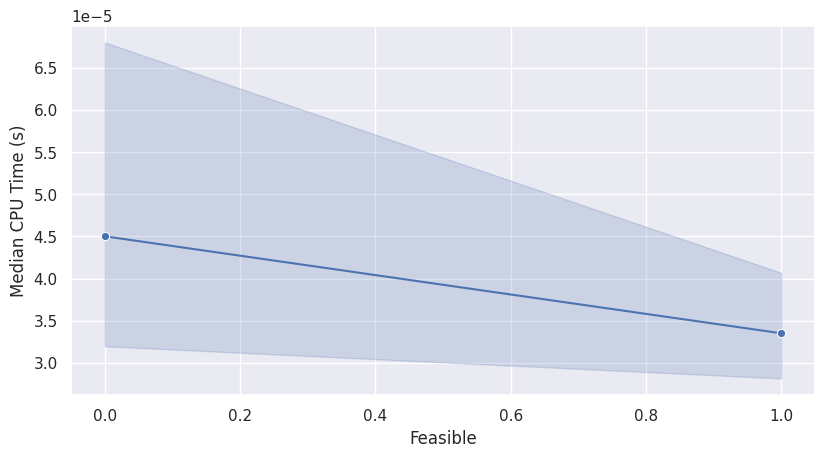

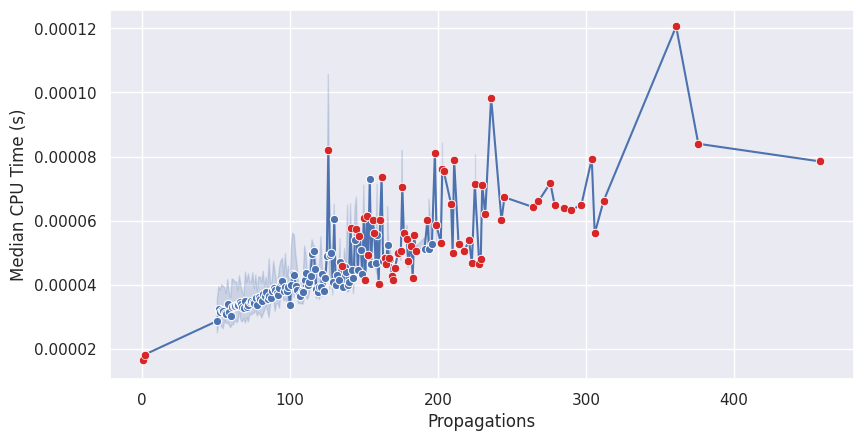

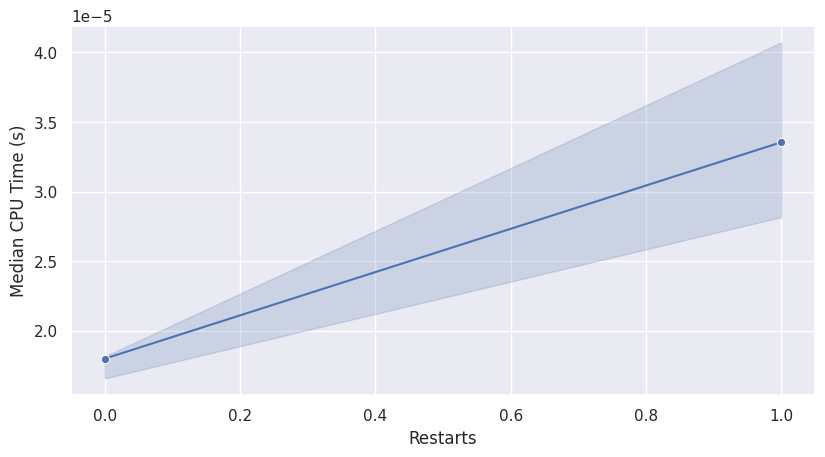

In [20]:
def find_ranges(data):
    if len(data) == 0:
        return
    data = sorted(data)
    start = end = data[0]
    for x in data[1:]:
        if x <= end + 1:
            end = x
        else:
            yield (start, end)
            start = end = x
    yield (start, end)


for metric in results.columns:
    if metric == "time_cpu":
        continue

    plt.figure(figsize=(9.6, 4.8))
    sns.lineplot(
        x=metric,
        y="time_cpu",
        estimator="median",
        errorbar=lambda x: np.percentile(x, [25, 75]),
        marker="o",
        data=results,
    )

    counts = results[metric].value_counts()
    infrequent_x = set(counts[counts < 3].index)
    to_mark = results[results[metric].isin(infrequent_x)]
    to_mark = to_mark.groupby(metric)["time_cpu"].median().reset_index()
    sns.scatterplot(x=metric, y="time_cpu", c='tab:red', data=to_mark, zorder=10000)

    plt.xlabel(metric.title())
    plt.ylabel("Median CPU Time (s)")
    savefig(f"figs/s2.1_{metric}_vs_time_median.png")


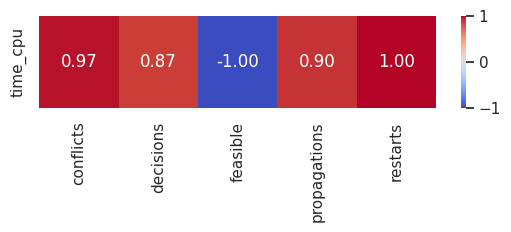

In [21]:
corr_median = pd.DataFrame(index=["time_cpu"], columns=results.columns, dtype=np.float64)
corr_median.drop("time_cpu", axis=1, inplace=True)

for m1 in results.columns:
    if m1 == "time_cpu":
        continue
    corr_val = results.groupby(m1)["time_cpu"].median().reset_index().corr("spearman").iloc[0, 1]
    corr_median.loc["time_cpu", m1] = corr_val

plt.figure(figsize=(6.4, 1.2))
sns.heatmap(corr_median, vmin=-1, vmax=1, cmap="coolwarm", annot=True, fmt=".2f")
savefig("figs/s2.1_metrics_corr_median.png")

#### 2.2. Analysis of intermediate rewards

## 3. Learning rate, action mode

In [22]:
s3_argmax = {}
s3_sample = {}

for lr in ('1e-3', '1e-4', '1e-5'):
    s3_argmax[lr] = load_history(f"s3 (metric=time_cpu, action_mode=argmax, lr={lr})")
    s3_sample[lr] = load_history(f"s3 (metric=time_cpu, action_mode=sample, lr={lr})")


Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-3)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-3)
Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-4)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-4)
Loaded history from s3 (metric=time_cpu, action_mode=argmax, lr=1e-5)
Loaded history from s3 (metric=time_cpu, action_mode=sample, lr=1e-5)


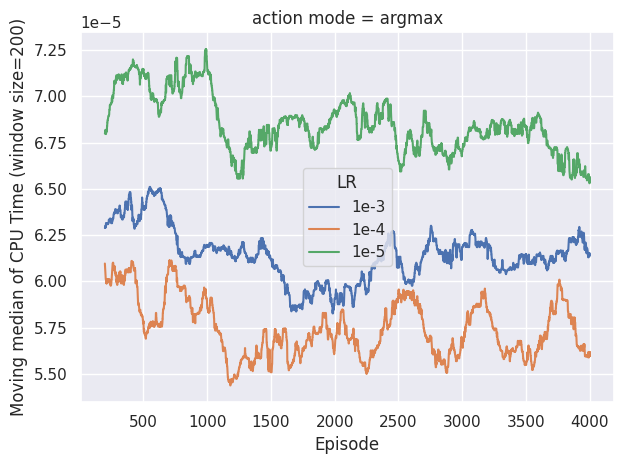

In [23]:
plot_metrics(
    s3_argmax,
    experiments_label="LR",
    saveto=f"figs/s3_argmax",
    title=f"action mode = argmax",
)


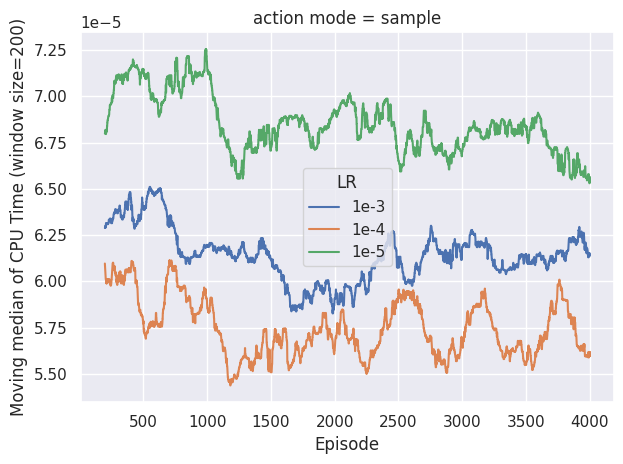

In [24]:
plot_metrics(
    s3_argmax,
    experiments_label="LR",
    saveto=f"figs/s3_sample",
    title=f"action mode = sample",
)


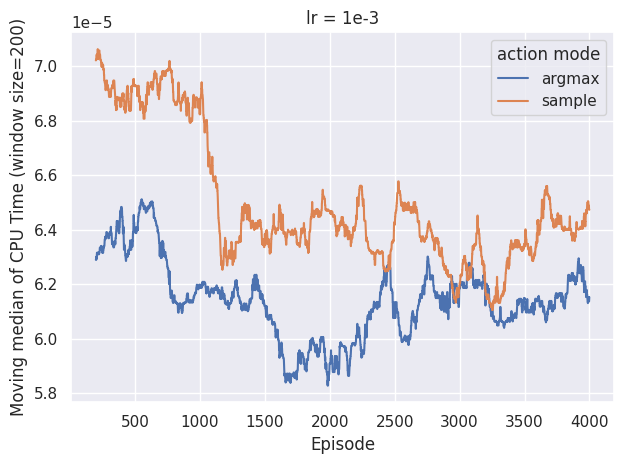

In [25]:
plot_metrics(
    {"argmax": s3_argmax["1e-3"], "sample": s3_sample["1e-3"]},
    experiments_label="action mode",
    saveto=f"figs/s3_lr=1e-3",
    title=f"lr = 1e-3",
)


## 4. Intermediate rewards, learning rate

In [26]:
s4_decisions = {}
s4_decisions_ov = {}
s4_time = {}
s4_time_ov = {}

for lr in ('1e-3', '1e-4', '1e-5'):
    s4_decisions[lr] = load_history(f"s4 (metric=decisions, lr={lr}, int_rewards)")
    s4_decisions_ov[lr] = load_history(f"s4 (metric=decisions, lr={lr}, overlaps, int_rewards)")
    s4_time[lr] = load_history(f"s4 (metric=time_cpu, lr={lr}, int_rewards)")
    s4_time_ov[lr] = load_history(f"s4 (metric=time_cpu, lr={lr}, overlaps, int_rewards)")

Loaded history from s4 (metric=decisions, lr=1e-3, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-3, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-3, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-3, overlaps, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-4, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-4, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-4, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-4, overlaps, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-5, int_rewards)
Loaded history from s4 (metric=decisions, lr=1e-5, overlaps, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-5, int_rewards)
Loaded history from s4 (metric=time_cpu, lr=1e-5, overlaps, int_rewards)


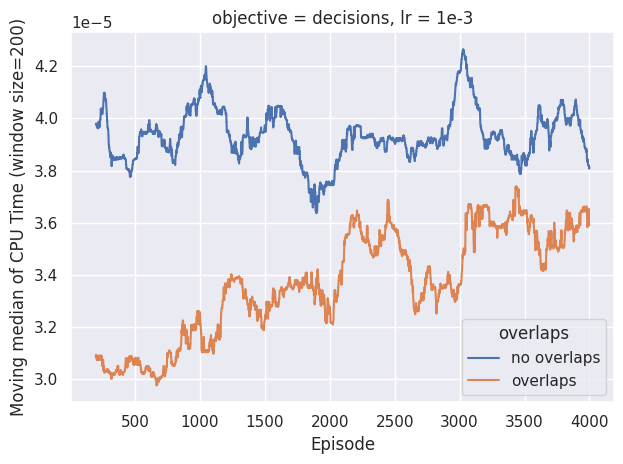

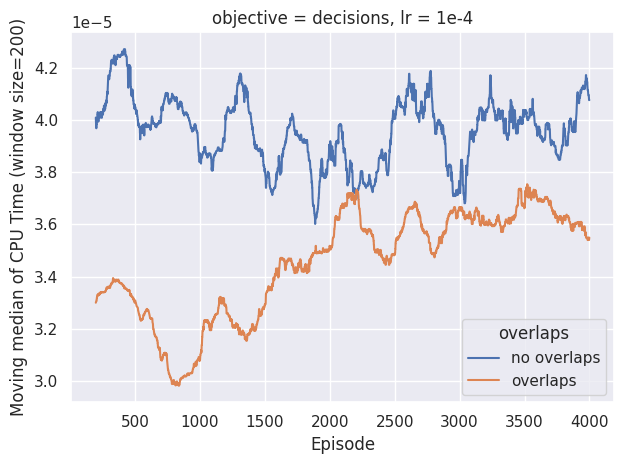

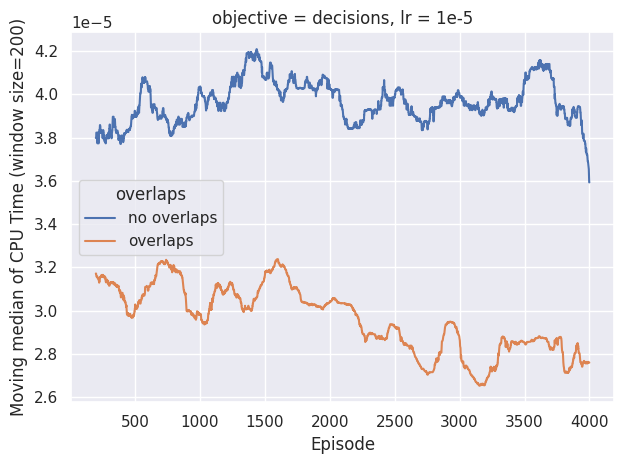

In [27]:
for lr in ("1e-3", "1e-4", "1e-5"):
    plot_metrics(
        {"no overlaps": s4_decisions[lr], "overlaps": s4_decisions_ov[lr]},
        experiments_label="overlaps",
        saveto=f"figs/s4_decisions_lr{lr}",
        title=f"objective = decisions, lr = {lr}",
    )


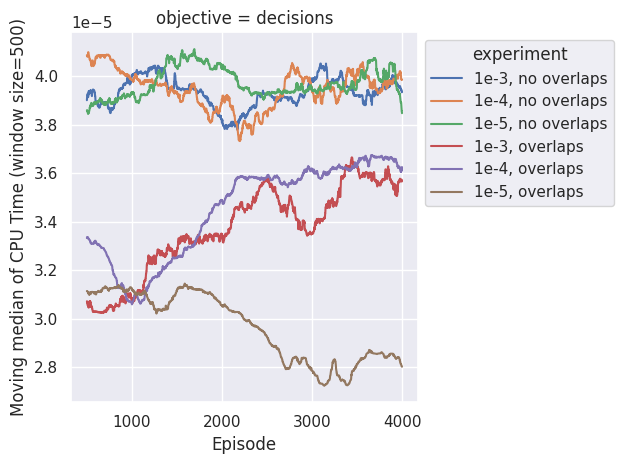

In [59]:
s4_decisions_all = {}
for k, v in s4_decisions.items():
    s4_decisions_all[k + ", no overlaps"] = v
for k, v in s4_decisions_ov.items():
    s4_decisions_all[k + ", overlaps"] = v

plot_metrics(
    s4_decisions_all,
    saveto=f"figs/s4_decisions_all",
    title=f"objective = decisions",
    window_size=500,
    move_legend=True,
)


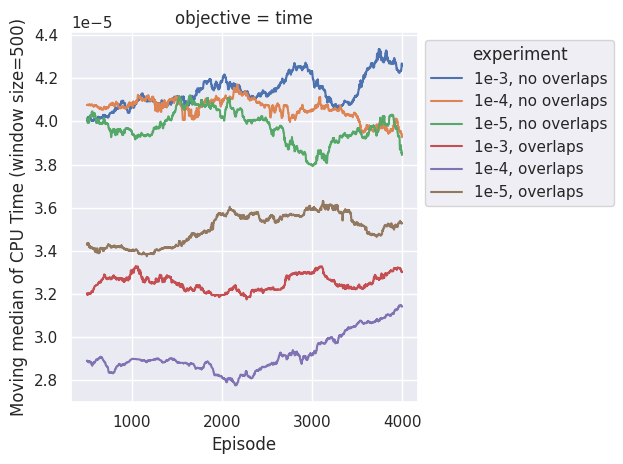

In [60]:
s4_time_all = {}
for k, v in s4_time.items():
    s4_time_all[k + ", no overlaps"] = v
for k, v in s4_time_ov.items():
    s4_time_all[k + ", overlaps"] = v

plot_metrics(
    s4_time_all,
    saveto=f"figs/s4_time_all",
    title=f"objective = time",
    window_size=500,
    move_legend=True,
)


In [71]:
scores_decisions = pd.DataFrame()
for lr in ("1e-3", "1e-4", "1e-5"):
    for ov in ("overlaps", "no overlaps"):
        df = s4_decisions_all[f"{lr}, {ov}"]
        scores_decisions.loc[ov, lr] = get_metrics_per_episode(df)["time_cpu"].iloc[-500:].median()

scores_time = pd.DataFrame()
for lr in ("1e-3", "1e-4", "1e-5"):
    for ov in ("overlaps", "no overlaps"):
        df = s4_time_all[f"{lr}, {ov}"]
        scores_time.loc[ov, lr] = get_metrics_per_episode(df)["time_cpu"].iloc[-500:].median()


display(scores_time)
display(scores_decisions)

,1e-3,1e-4,1e-5
overlaps,0.000033,0.000031,0.000035
no overlaps,0.000043,0.000039,0.000038


,1e-3,1e-4,1e-5
overlaps,0.000036,0.000036,0.000028
no overlaps,0.000039,0.000040,0.000038


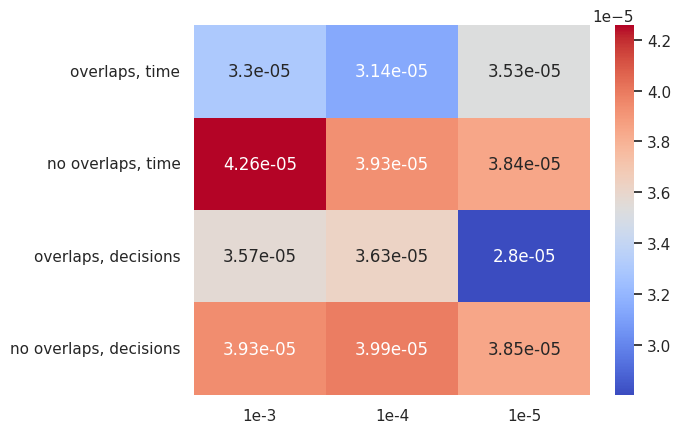

In [72]:
scores_time.index = [i + ", time" for i in scores_time.index]
scores_decisions.index = [i + ", decisions" for i in scores_decisions.index]
sns.heatmap(pd.concat([scores_time, scores_decisions]), cmap="coolwarm", annot=True, fmt=".3g")
savefig("figs/s4_matrix")

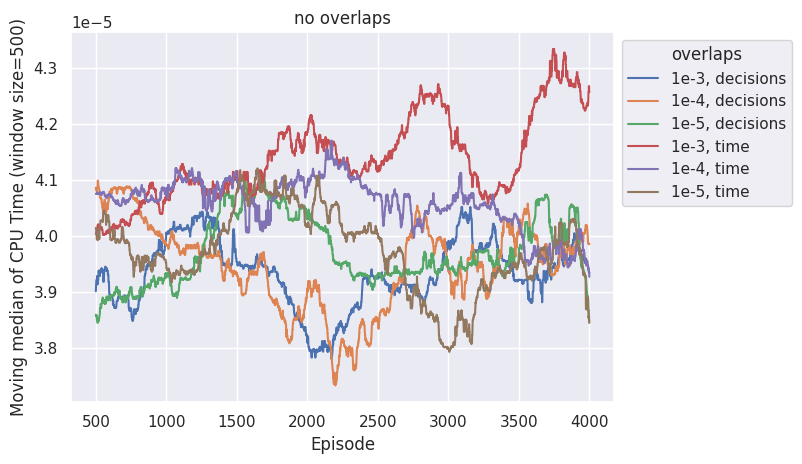

In [48]:
s4_no_ov = {}
for k, v in s4_decisions.items():
    s4_no_ov[k + ", decisions"] = v
for k, v in s4_time.items():
    s4_no_ov[k + ", time"] = v

plot_metrics(
    s4_no_ov,
    experiments_label="overlaps",
    saveto=f"figs/s4_no_ov",
    title=f"no overlaps",
    window_size=500,
)
sns.move_legend(plt.gca(), loc="upper left", bbox_to_anchor=(1, 1))


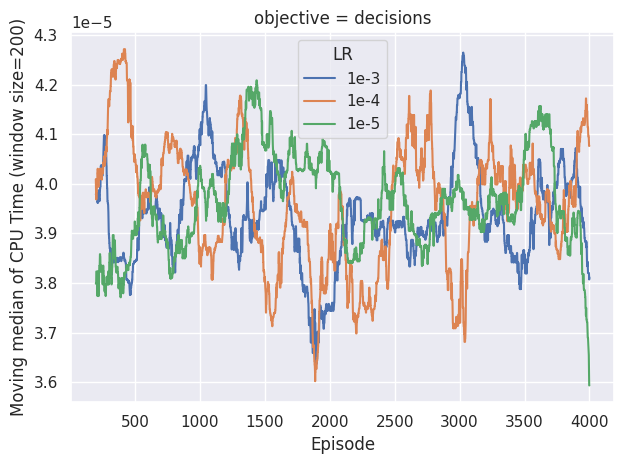

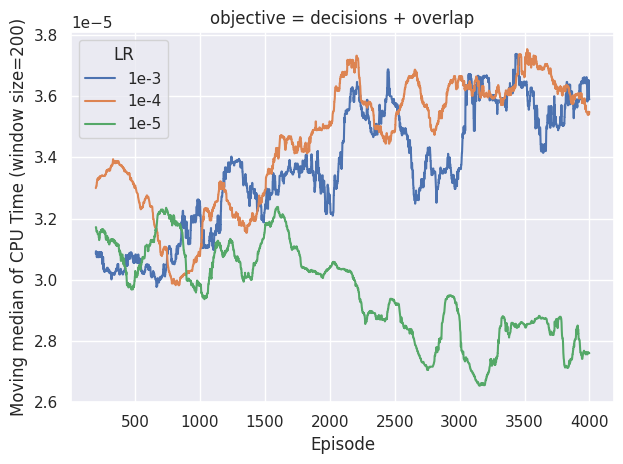

In [45]:
plot_metrics(
    s4_decisions,
    experiments_label="LR",
    saveto=f"figs/s4_decisions",
    title=f"objective = decisions",
)
plot_metrics(
    s4_decisions_ov,
    experiments_label="LR",
    saveto=f"figs/s4_decisions_ov",
    title=f"objective = decisions + overlap",
)


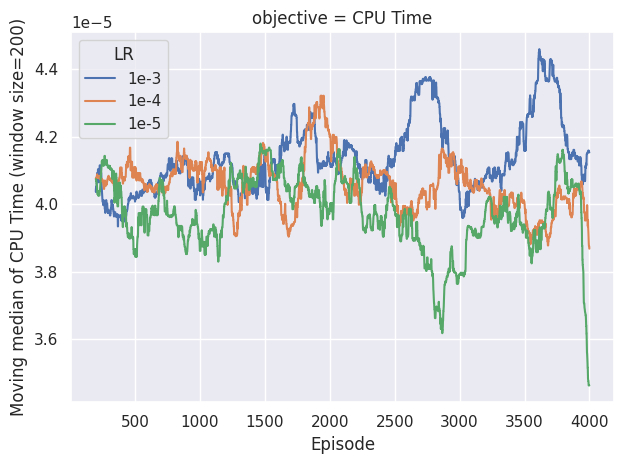

In [33]:
plot_metrics(
    s4_time,
    experiments_label="LR",
    saveto=f"figs/s4_time_cpu",
    title=f"objective = CPU Time",
)


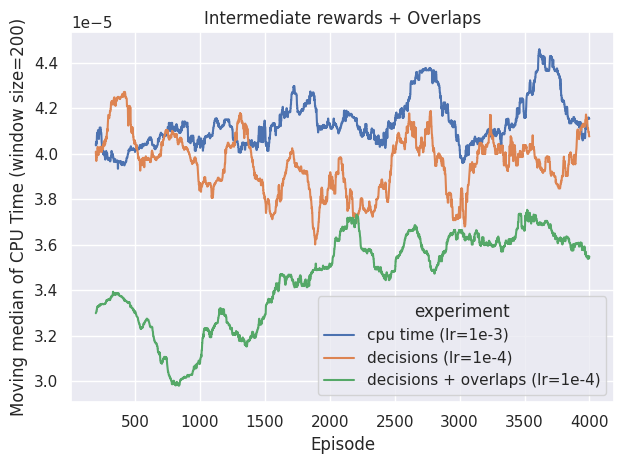

In [50]:
plot_metrics(
    {
        "cpu time (lr=1e-3)": s4_time["1e-3"],
        "decisions (lr=1e-4)": s4_decisions["1e-4"],
        "decisions + overlaps (lr=1e-4)": s4_decisions_ov["1e-4"],
    },
    saveto=f"figs/s4_best",
    title=f"Intermediate rewards + Overlaps",
)


## 5. Fixed templates

In [37]:
s5 = {}

for run in range(1, 4):
    s5[f"fixed (run {run})"] = load_history(f"s5 (template_mode=fixed_random, run {run})")
s5[f"random"] = load_history(f"s5 (template_mode=random)")


Loaded history from s5 (template_mode=fixed_random, run 1)
Loaded history from s5 (template_mode=fixed_random, run 2)
Loaded history from s5 (template_mode=fixed_random, run 3)
Loaded history from s5 (template_mode=random)


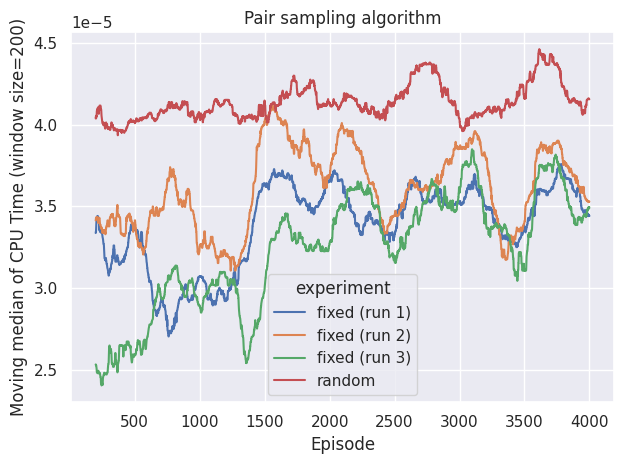

In [38]:
plot_metrics(
    s5,
    saveto=f"figs/s5",
    title=f"Pair sampling algorithm",
)


## 6. Action mode

In [41]:
s6 = {}
s6_keys = [
    "decisions, lr=1e-4",
    "decisions, lr=1e-4, overlaps",
    "time_cpu, lr=1e-3",
]

for k in s6_keys:
    s6[k + ", sample"] = load_history(f"s6 (metric={k}, int_rewards, action_mode=sample)")
    s6[k + ", argmax"] = load_history(f"s6 (metric={k}, int_rewards, action_mode=argmax)")


Loaded history from s6 (metric=decisions, lr=1e-4, int_rewards, action_mode=sample)
Loaded history from s6 (metric=decisions, lr=1e-4, int_rewards, action_mode=argmax)
Loaded history from s6 (metric=decisions, lr=1e-4, overlaps, int_rewards, action_mode=sample)
Loaded history from s6 (metric=decisions, lr=1e-4, overlaps, int_rewards, action_mode=argmax)
Loaded history from s6 (metric=time_cpu, lr=1e-3, int_rewards, action_mode=sample)
Loaded history from s6 (metric=time_cpu, lr=1e-3, int_rewards, action_mode=argmax)


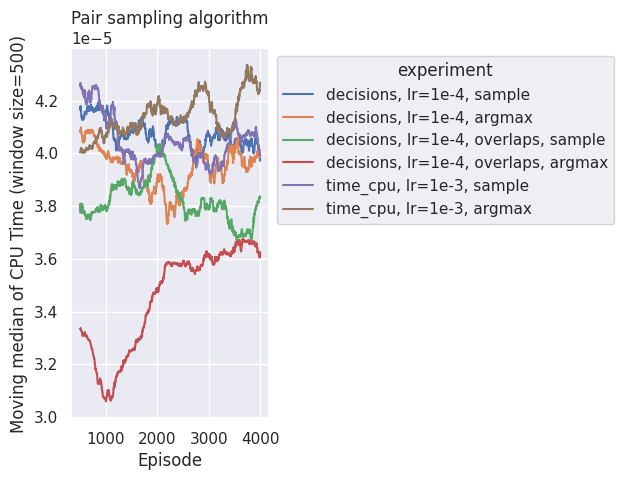

In [73]:
plot_metrics(
    s6,
    saveto=f"figs/s6",
    window_size=500,
    title=f"Pair sampling algorithm",
    move_legend=True,
)


## 7. Longer runs

In [51]:
s7 = {}
s7_keys = [
    "decisions, lr=1e-4",
    "decisions, lr=1e-4, overlaps",
    "time_cpu, lr=1e-3",
]

for k in s7_keys:
    s7[k] = load_history(f"s7 (metric={k}, int_rewards)")


Loaded history from s7 (metric=decisions, lr=1e-4, int_rewards)
Loaded history from s7 (metric=decisions, lr=1e-4, overlaps, int_rewards)
Loaded history from s7 (metric=time_cpu, lr=1e-3, int_rewards)


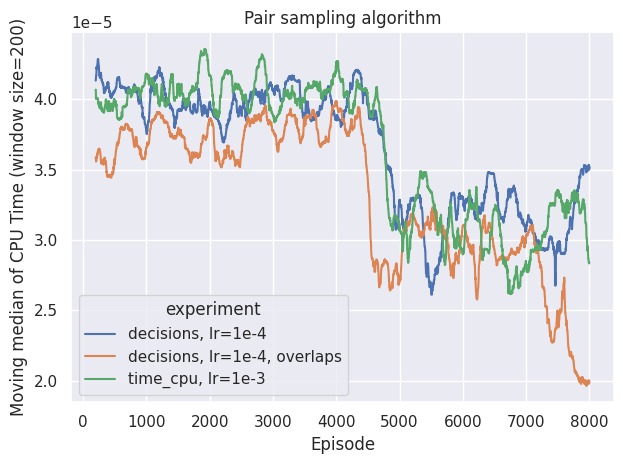

In [52]:
plot_metrics(
    s7,
    saveto=f"figs/s7",
    title=f"Pair sampling algorithm",
)


(4000.0, 5000.0)

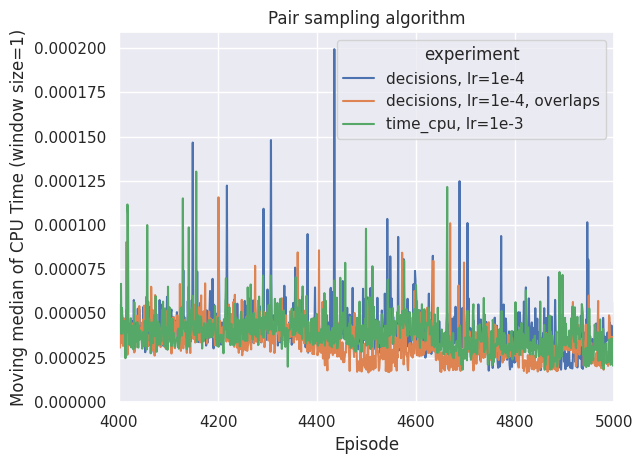

In [81]:
plot_metrics(
    s7,
    window_size=1,
    title=f"Pair sampling algorithm",
)
plt.xlim(4000, 5000)


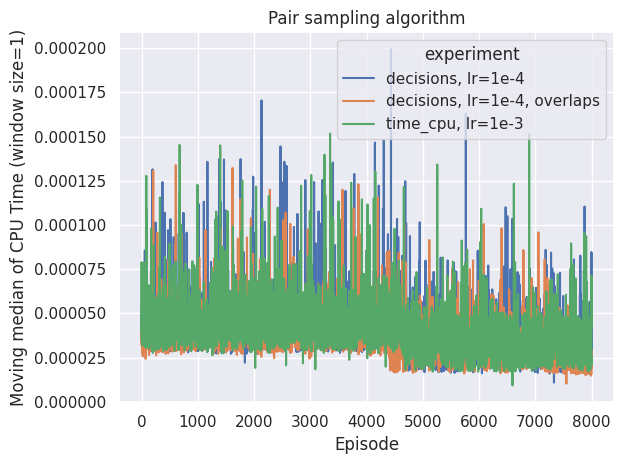

In [82]:
plot_metrics(
    s7,
    window_size=1,
    title=f"Pair sampling algorithm",
)
